## Part 1: 
Load data, clean, and save aggregate data

In [2]:
import pandas as pd 
import os
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import nfl_data_py as nfl
from data_cleaning import label_run_or_pass, reverse_deg, normalize_tracking
from data_loading import aggregate_data
root_dir = os.getcwd()

load_saved_data = True            # if you change this to true you can load presaved data

if not load_saved_data: 
    games_fname= os.path.join(root_dir, "data/games.csv")
    plays_fname = os.path.join(root_dir, "data/plays.csv")
    players_fname = os.path.join(root_dir, "data/players.csv")
    player_plays_fname = os.path.join(root_dir, "data/player_play.csv")
    tracking_fname_list_train = [os.path.join(root_dir, f"data/tracking_week_{i}.csv") for i in range(1,9)] #weeks 1-8 are training data
    tracking_fname_list_test = [os.path.join(root_dir, "data/tracking_week_9.csv")] #week 9 is test data
    train_data=aggregate_data(plays_fname, player_plays_fname, players_fname, tracking_fname_list_train, games_fname)
    train_data.to_csv(os.path.join(root_dir, "data/train_data.csv"))
    test_data=aggregate_data(plays_fname, player_plays_fname, players_fname, tracking_fname_list_test, games_fname )
    test_data.to_csv(os.path.join(root_dir, "data/test_data.csv"))
else:
    train_data=pd.read_csv(os.path.join(root_dir, "data/train_data.csv"))
    test_data=pd.read_csv(os.path.join(root_dir, "data/test_data.csv"))


C:\Users\meagv\AppData\Local\Temp\ipykernel_15424\3628356773.py:25: DtypeWarning: Columns (93,99) have mixed types. Specify dtype option on import or set low_memory=False.
  train_data=pd.read_csv(os.path.join(root_dir, "data/train_data.csv"))
C:\Users\meagv\AppData\Local\Temp\ipykernel_15424\3628356773.py:26: DtypeWarning: Columns (93,99) have mixed types. Specify dtype option on import or set low_memory=False.
  test_data=pd.read_csv(os.path.join(root_dir, "data/test_data.csv"))


In [2]:
#immport necessary libraries and filter warnings
from IPython.display import Image
import gc
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import os
from sklearn.dummy import DummyClassifier
from sklearn.metrics import mean_squared_error, f1_score, precision_score, recall_score, accuracy_score, cohen_kappa_score, roc_auc_score, confusion_matrix, log_loss, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold,StratifiedGroupKFold, train_test_split, KFold, cross_val_score
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.base import clone
from sklearn.pipeline import Pipeline
from scipy.optimize import minimize
from IPython.display import clear_output
from sklearn.decomposition import PCA
from colorama import Fore, Style
from tqdm import tqdm
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
import xgboost as xgb
import optuna
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import SimpleRNN, Embedding, Dense, Dropout
from keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import Callback
import nfl_data_py as nfl
from sklearn.impute import SimpleImputer

## Goal: 
To predict pass attempts for each play with greater accuracy and precision than the baseline dummy classifier. The base rate is about 60%. We will look at the offensive players' tracking data, along with characteristics of the play including the offensive formation and receiver alignment. 

## General Strategy:
1. Read all data
2. Merge data
3. Filter data for offensive players, plays not nullified by a penalty, and data before the snap
4. Create a target variable 'pass' to indicate if a pass was attempted
5. Feature engineering and feature selection
6. Test baseline models
7. Tune models

In [3]:
#helper functions
#change all plays to same direction
def reverse_deg(deg):
    if deg < 180:
        return deg + 180
    if deg >= 18:
        return deg - 180

#merge all data specifically to pull the data for the team in possession during the play
def merge_clean_data(df_tracking, df_plays, df_player_plays):
    df_final=pd.merge(pd.merge(df_tracking, df_plays, left_on=[ 'gameId', 'playId','club'], right_on=[ 'gameId', 'playId', 'possessionTeam'], how='inner'), df_player_plays, left_on=[ 'gameId', 'playId', 'nflId'], right_on=[ 'gameId', 'playId', 'nflId'], how='left' )
    df_final=pd.merge(df_final, df_games, on='gameId', how='inner')
    del df_tracking
    gc.collect()
    df_final=pd.merge(df_final, df_players, on='nflId', how='inner')
    return df_final

In [4]:
#read games, players, plays, and player_plays data
file='/kaggle/input/nfl-big-data-bowl-2025/'
df_games=pd.read_csv(file+'games.csv')
df_players=pd.read_csv(file+'players.csv')
df_players.loc[df_players['nflId'] ==45244, 'position'] = 'TE' #update data for Taysom Hill
df_plays=pd.read_csv(file+'plays.csv')
#pull stadium data for current season games
df_stadium=nfl.import_schedules([2022])
df_stadium=df_stadium[df_stadium['week']<=9][[ 'old_game_id','roof', 'surface']]

#get game weather
df_games_weather=nfl.import_pbp_data(years=[2022])[['old_game_id_x',  'weather' ]].drop_duplicates()
df_games_weather['gameId']=df_games_weather['old_game_id_x'].astype(int)
df_games_weather['Rain']=np.where(df_games_weather['weather'].str.contains('Rain'), 1, 0)
df_games_weather[['temp', 'humidity', 'wind']]=df_games_weather['weather'].str.split(',', expand=True).iloc[:, :3]
df_games_weather['temp'] = df_games_weather['temp'].str.split(':', expand=True).iloc[:, 1:2]
df_games_weather['temp']=df_games_weather['temp'].str.extract('(\d+)')
df_games_weather['humidity'] = df_games_weather['humidity'].str.extract('(\d+)')
df_games_weather['wind'] = df_games_weather['wind'].str.extract('(\d+)')

df_games=pd.merge(df_games, df_stadium,left_on='gameId', right_on='old_game_id', how='left')
df_games=pd.merge(df_games, df_games_weather,on='gameId', how='left')



2022 done.
Downcasting floats.


In [5]:
#pull previous year pass rush data by team
df_player_plays=pd.read_csv(file+'player_play.csv')
df_rush2021=nfl.import_ngs_data(stat_type='rushing', years=[2021])[['team_abbr', 'rush_attempts']].groupby('team_abbr').sum().reset_index()
df_pass2021=nfl.import_ngs_data(stat_type='passing', years=[2021])[['team_abbr', 'attempts']].groupby('team_abbr').sum().reset_index()
df_pass_rush2021=pd.merge(df_rush2021, df_pass2021, on='team_abbr', how='outer')
df_pass_rush2021['pass_rush_ratio']=np.round((df_pass_rush2021['attempts']/df_pass_rush2021['rush_attempts']), 2)
df_pass_rush2021.drop(columns=['rush_attempts', 'attempts'], inplace=True)
df_player_plays=pd.merge(df_player_plays, df_pass_rush2021, left_on='teamAbbr', right_on='team_abbr', how='outer')


In [6]:
#features for plays df 
df_plays['time_remaining'] = df_plays['quarter'].map({1: 45, 2: 30, 3: 15, 4: 0}) + \
                               df_plays['gameClock'].apply(lambda x: int(x.split(':')[0]) + int(x.split(':')[1])/60)
df_plays['score_differential'] = df_plays['preSnapHomeScore'] - df_plays['preSnapVisitorScore']

In [7]:
exclude_events=['huddle_break_offense'] #exclude frame with huddle break event
tracking_files=[]
for i in range(1,9):  #read some or all of weeks tracking data
    file='/kaggle/input/nfl-big-data-bowl-2025/tracking_week_'+str(i)+'.csv'
    df_tracking=pd.read_csv(file)
    df_tracking=df_tracking[ (df_tracking['frameType']=='BEFORE_SNAP')& (~df_tracking['event'].isin(exclude_events))]
    df_tracking['gameplayId']=df_tracking['gameId'].astype(str)+'_'+df_tracking['playId'].astype(str)
    playstodrop=df_tracking[df_tracking['event'].isin(['huddle_start_offense', 'timeout_away'])][['gameplayId']].drop_duplicates() #plays with huddle start or timeout we should drop
    df_tracking = df_tracking[~df_tracking['gameplayId'].isin(playstodrop['gameplayId'])]
    
    #nromalize o, dir, x, y
    df_tracking['o_standard']=np.where(df_tracking["playDirection"] == "left",df_tracking['o'].apply(reverse_deg), df_tracking['o'])
    df_tracking['dir_standard']=np.where(df_tracking["playDirection"] == "left",df_tracking['dir'].apply(reverse_deg), df_tracking['dir'])
    df_tracking["x_standard"] = np.where(df_tracking["playDirection"] == "left", df_tracking["x"].apply(lambda x: 120 - x), df_tracking["x"])
    df_tracking["y_standard"] =np.where(df_tracking["playDirection"] == "left",  df_tracking["y"].apply(lambda y: 160/3 - y), df_tracking["y"])
   
    df_tracking=df_tracking[['gameId', 'playId', 'nflId','club' ,'o_standard', 'dir_standard', 'x_standard', 'y_standard', 's', 'a', 'dis']].groupby(['gameId', 'playId', 'nflId','club']).agg({'s':[ 'max',],'a':[ 'max'], 
    'o_standard':['mean', 'std'],'dis':['sum'],'dir_standard':['mean', 'std'], 'x_standard':['mean', 'std'], 'y_standard':['mean', 'std']}).reset_index()
    df_tracking.columns=df_tracking.columns.map('|'.join).str.strip('|')
    #filter on before snap and exclude the specific events
    #merge all data
    merged=merge_clean_data(df_tracking, df_plays, df_player_plays)
    del df_tracking
    #drop unnecessary columns to save memory
    merged.drop(columns=[   'playDescription',
          'possessionTeam', 'defensiveTeam',
           'yardlineSide', 'yardlineNumber', 'gameClock', 
             'expectedPoints',
          'playClockAtSnap',
          'passLength', 'targetX', 'targetY', 'playAction',
           'dropbackType', 'dropbackDistance', 'passLocationType',
           'timeToThrow', 'timeInTackleBox', 'timeToSack', 'passTippedAtLine',
           'unblockedPressure', 'qbSpike', 'qbKneel', 'qbSneak',
           'rushLocationType', 'penaltyYards_x', 'prePenaltyYardsGained',
           'yardsGained', 'homeTeamWinProbabilityAdded',
           'visitorTeamWinProbilityAdded', 'expectedPointsAdded',
            'pff_runConceptPrimary', 'pff_runConceptSecondary',
           'pff_runPassOption', 'pff_passCoverage',  'teamAbbr',
           'hadRushAttempt', 'rushingYards', 'hadDropback', 'passingYards',
           'sackYardsAsOffense', 'hadPassReception', 'receivingYards',
           'wasTargettedReceiver', 'yardageGainedAfterTheCatch', 'fumbles',
           'fumbleLost', 'fumbleOutOfBounds', 'assistedTackle',
           'forcedFumbleAsDefense', 'halfSackYardsAsDefense', 'passDefensed',
           'quarterbackHit', 'sackYardsAsDefense', 'safetyAsDefense',
           'soloTackle', 'tackleAssist', 'tackleForALoss',
           'tackleForALossYardage', 'hadInterception', 'interceptionYards',
           'fumbleRecoveries', 'fumbleRecoveryYards', 'penaltyYards_y',
           'penaltyNames', 'wasInitialPassRusher', 'causedPressure',
           'timeToPressureAsPassRusher', 'getOffTimeAsPassRusher',
           'inMotionAtBallSnap', 
           'wasRunningRoute', 'routeRan', 'blockedPlayerNFLId1','pff_manZone',
           'blockedPlayerNFLId2', 'blockedPlayerNFLId3',
           'pressureAllowedAsBlocker', 'timeToPressureAllowedAsBlocker',
           'pff_defensiveCoverageAssignment',
           'pff_primaryDefensiveCoverageMatchupNflId',
           'pff_secondaryDefensiveCoverageMatchupNflId', 'height', 'weight','season', 'team_abbr',  'season', 'week',
       'gameDate', 'gameTimeEastern', 'homeTeamAbbr', 'visitorTeamAbbr',
       'homeFinalScore', 'visitorFinalScore', 'old_game_id', 'old_game_id_x', 'weather',
           'birthDate', 'collegeName'], inplace=True)
        #get the count of players in each position for each play and take the max
    merged['pos_count']=(merged[['gameId', 'playId', 'position', 'nflId']].drop_duplicates().sort_values(by=['gameId', 'playId', 'position']).groupby(by=['gameId', 'playId', 'position']).cumcount()+1)
    merged['pos_count'].fillna(99, inplace=True)
    merged['pos_count']=merged['pos_count'].astype(int)
    #create a position_pivot column so that each player has a unique value during the play
    merged['position_pivot']=merged['position']+'_'+merged['pos_count'].astype(str)
    tracking_files.append(merged)
    del merged
    gc.collect()
merged=pd.concat(tracking_files)

In [8]:
#create 'pass' variable for pass attempt play based on isDropback=True

merged['pass']=np.where(merged['isDropback']==True, 1, 0)


In [9]:
merged_pivot=merged.pivot(index=['gameId', 'playId','quarter', 'down', 'yardsToGo', 'score_differential', 'time_remaining', 'playNullifiedByPenalty','preSnapHomeTeamWinProbability', 'pass_rush_ratio', 'roof', 'surface', 'Rain', 'temp', 'humidity', 'wind',
           'preSnapVisitorTeamWinProbability',
           'absoluteYardlineNumber', 'offenseFormation', 'receiverAlignment',
           'pass'], columns=['position_pivot'], values=['s|max', 'a|max',
       'o_standard|mean', 'o_standard|std', 'dis|sum', 'dir_standard|mean',
       'dir_standard|std', 'x_standard|mean', 'x_standard|std',
       'y_standard|mean', 'y_standard|std', 'shiftSinceLineset', 'motionSinceLineset']).fillna(0).reset_index() 
merged_pivot.columns =merged_pivot.columns.map('|'.join).str.strip('|')
merged_pivot.replace({False:0, True:1}, inplace=True)

In [10]:
del merged
gc.collect()

7

In [11]:
#merged_pivot=pd.get_dummies(merged_pivot, columns=['offenseFormation','receiverAlignment','pff_manZone', 'roof', 'surface'],dtype=int)
# Define categorical and numerical columns

merged_pivot = pd.get_dummies(merged_pivot, columns=['offenseFormation','receiverAlignment', 'roof', 'surface'])



In [12]:
for col in merged_pivot.columns: 
    if round((merged_pivot[col].isna().sum() /len(merged_pivot)*100), 2)>75:
        merged_pivot.drop(columns=col, inplace=True)
    elif round((merged_pivot[col].isna().sum() /len(merged_pivot)*100), 2)>0:
        print(col,round((merged_pivot[col].isna().sum() /len(merged_pivot)*100), 2), '% missing')
    else: 
        print(col)

gameId
playId
quarter
down
yardsToGo
score_differential
time_remaining 0.81 % missing
playNullifiedByPenalty
preSnapHomeTeamWinProbability
pass_rush_ratio 2.84 % missing
Rain
temp 9.67 % missing
humidity 5.64 % missing
wind 8.97 % missing
preSnapVisitorTeamWinProbability
absoluteYardlineNumber
pass
s|max|C_1
s|max|C_2
s|max|DT_1
s|max|FB_1
s|max|FS_1
s|max|G_1
s|max|G_2
s|max|G_3
s|max|G_4
s|max|ILB_1
s|max|OLB_1
s|max|QB_1
s|max|QB_2
s|max|RB_1
s|max|RB_2
s|max|RB_3
s|max|TE_1
s|max|TE_2
s|max|TE_3
s|max|TE_4
s|max|T_1
s|max|T_2
s|max|T_3
s|max|T_4
s|max|WR_1
s|max|WR_2
s|max|WR_3
s|max|WR_4
s|max|WR_5
a|max|C_1
a|max|C_2
a|max|DT_1
a|max|FB_1
a|max|FS_1
a|max|G_1
a|max|G_2
a|max|G_3
a|max|G_4
a|max|ILB_1
a|max|OLB_1
a|max|QB_1
a|max|QB_2
a|max|RB_1
a|max|RB_2
a|max|RB_3
a|max|TE_1
a|max|TE_2
a|max|TE_3
a|max|TE_4
a|max|T_1
a|max|T_2
a|max|T_3
a|max|T_4
a|max|WR_1
a|max|WR_2
a|max|WR_3
a|max|WR_4
a|max|WR_5
o_standard|mean|C_1
o_standard|mean|C_2
o_standard|mean|DT_1
o_standard|mean|F

### Add pass-rate data

In [13]:
xp_df = pd.read_csv('/kaggle/input/created-data-db-25/team_xpass_ratios.csv').drop(columns='Unnamed: 0')
pr_df = pd.read_csv('/kaggle/input/created-data-db-25/team_pass_rates.csv').drop(columns='Unnamed: 0')

### Add FTN data

In [14]:
pbp = nfl.import_pbp_data([2022])
ftn = nfl.import_ftn_data([2022])

2022 done.
Downcasting floats.
Downcasting floats.


In [15]:
pbp_ids = pbp[['play_id','game_id','old_game_id_x']]
ftn['nflverse_play_id'] = ftn['nflverse_play_id'].astype(int)
pbp_ids['play_id'] = pbp_ids['play_id'].astype(int)
ftn['nflverse_game_id'] = ftn['nflverse_game_id'].astype(str)
pbp_ids['game_id'] = pbp_ids['game_id'].astype(str)
ftn.head(1)

,ftn_game_id,nflverse_game_id,season,week,ftn_play_id,nflverse_play_id,starting_hash,qb_location,n_offense_backfield,n_defense_box,...,read_thrown,is_catchable_ball,is_contested_ball,is_created_reception,is_drop,is_qb_sneak,n_blitzers,n_pass_rushers,is_qb_fault_sack,date_pulled
0,5879,2022_01_BUF_LA,2022,1,963918,56,R,S,1,6,...,1,True,False,False,False,False,0,4,False,2024-09-06 23:50:14.696374+00:00


In [16]:
ftn_merged = pbp_ids.merge(ftn,how='left',left_on=['play_id','game_id'],
              right_on=['nflverse_play_id','nflverse_game_id'])

ftn_merged = ftn_merged[['play_id','old_game_id_x','n_offense_backfield',
                        'n_defense_box','is_no_huddle','is_motion']].rename(columns={'old_game_id_x':'gameId',
                                                                                    'play_id':'playId'})

ftn_merged['gameId'] = ftn_merged['gameId'].astype(int)
ftn_merged['playId'] = ftn_merged['playId'].astype(int)

merged_id_df = merged_pivot[['gameId','playId']]

In [17]:
df_plays.head(1)

,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,defensiveTeam,yardlineSide,yardlineNumber,...,visitorTeamWinProbilityAdded,expectedPointsAdded,isDropback,pff_runConceptPrimary,pff_runConceptSecondary,pff_runPassOption,pff_passCoverage,pff_manZone,time_remaining,score_differential
0,2022102302,2655,(1:54) (Shotgun) J.Burrow pass short middle to...,3,1,10,CIN,ATL,CIN,21,...,-0.004634,0.702717,True,NaN,NaN,0,Cover-3,Zone,16.9,18


### Merge in FTN and pass rate data

In [18]:
merged_base = merged_id_df.merge(ftn_merged,how='left',on=['gameId','playId'])
merged_base = merged_base.merge(pr_df,how='left',on=['gameId','playId'])
merged_base = merged_base.merge(xp_df,how='left',on=['gameId','playId'])

### Add coverage data

In [19]:
merged_base.sample(3)

,gameId,playId,n_offense_backfield,n_defense_box,is_no_huddle,is_motion,pass_rate_off,pass_rate_def,off_xpass,def_xpass
5081,2022092509,2852,2.0,7.0,False,True,0.616667,0.715596,0.508127,0.668140
3038,2022091808,1117,0.0,5.0,False,True,0.500000,0.703125,0.494547,0.701578
4146,2022092502,1445,1.0,7.0,False,False,0.646617,0.682171,0.739927,0.688540


In [20]:
merged_base = merged_base.merge(df_games[['gameId','week']].drop_duplicates(),how='left',on=['gameId'])

In [21]:
cf_df = pd.read_csv('/kaggle/input/created-data-db-25/coverages_faced.csv').drop(columns='Unnamed: 0')
cu_df = pd.read_csv('/kaggle/input/created-data-db-25/coverages_used.csv').drop(columns='Unnamed: 0')

In [22]:
merged_base = merged_base.merge(df_plays[['gameId','playId',
                                          'possessionTeam','defensiveTeam']].drop_duplicates(),
                                how='left',on=['gameId','playId'])

In [23]:
merged_base.sample(3)

,gameId,playId,n_offense_backfield,n_defense_box,is_no_huddle,is_motion,pass_rate_off,pass_rate_def,off_xpass,def_xpass,week,possessionTeam,defensiveTeam
202,2022091100,2899,1.0,6.0,True,False,NaN,NaN,NaN,NaN,1,ATL,NO
6530,2022100206,856,1.0,6.0,False,False,0.673797,0.516746,0.797615,0.398721,4,LAC,HOU
12637,2022102311,3042,0.0,4.0,False,False,0.660969,0.603015,0.778477,0.648225,7,MIA,PIT


In [24]:
cf_df.head(1)

,possessionTeam,week,cover_3_off,cover_6_off,cover_1_off,Quarters_off,Cover-2_off,Cover-0_off,Man_off,Other_off,Zone_off
0,ARI,2,8,3,11,16,14,2,13,3,41


In [25]:
merged_base = merged_base.merge(cf_df,how='left',on=['possessionTeam','week'])
merged_base = merged_base.merge(cu_df,how='left',on=['defensiveTeam','week'])

In [26]:
#merged_base = merged_base.fillna(merged_base.mean())

In [27]:
merged_pivot = pd.concat([merged_pivot,merged_base.iloc[:,2:]],axis=1)

In [28]:
merged_pivot[['is_no_huddle']] = merged_pivot[['is_no_huddle']].astype(int)
merged_pivot[['is_motion']] = merged_pivot[['is_motion']].astype(int)

In [29]:
merged_pivot['temp']=merged_pivot['temp'].astype(float)
merged_pivot['humidity']=merged_pivot['humidity'].astype(float)
merged_pivot['wind']=merged_pivot['wind'].astype(float)

In [30]:
merged_pivot.head(1)

,gameId,playId,quarter,down,yardsToGo,score_differential,time_remaining,playNullifiedByPenalty,preSnapHomeTeamWinProbability,pass_rush_ratio,...,Zone_off,cover_3_def,cover_6_def,cover_1_def,Quarters_def,Cover-2_def,Cover-0_def,Man_def,Other_def,Zone_def
0,2022090800,56,1,1,10,0,60.0,N,0.413347,2.72,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
drop_columns=['playNullifiedByPenalty', 'gameId', 'playId']
features=[]
for col in merged_pivot.columns:
    if 'Id' not in col and 'playNullifiedByPenalty' not in col:
        features.append(col)


In [32]:
#select final features based on correlation with target variable
correlations=merged_pivot[features].corr()[['pass']]
final_features=list(correlations[((correlations['pass']>.02) | (correlations['pass']<-.02))].T.columns.values)


In [33]:
final_features = [x for x in final_features if 'std' not in x]

In [34]:
merged_pivot[final_features].sum().astype(int).sort_values().head(20)

shiftSinceLineset|G_1         5
receiverAlignment_1x0         7
shiftSinceLineset|T_2         8
shiftSinceLineset|QB_1        9
motionSinceLineset|WR_4      10
s|max|TE_4                   10
shiftSinceLineset|G_2        12
shiftSinceLineset|T_1        12
a|max|TE_4                   18
dis|sum|TE_4                 35
receiverAlignment_2x0        42
shiftSinceLineset|TE_3       71
offenseFormation_WILDCAT     79
receiverAlignment_4x1       109
offenseFormation_JUMBO      116
a|max|G_4                   122
receiverAlignment_1x1       143
shiftSinceLineset|FB_1      149
a|max|WR_4                  180
s|max|WR_4                  249
dtype: int64

In [35]:
final_features= merged_pivot[final_features].sum().astype(int).sort_values().index[8:]

In [36]:
#remove redundant features
threshold = .8
correlation_matrix = merged_pivot[final_features].drop(columns='pass').corr()
highly_correlated_features = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            colname = correlation_matrix.columns[i]
            highly_correlated_features.add(colname)

In [37]:
final_features=list(set(final_features)-highly_correlated_features)


In [38]:
len(final_features)

97

In [39]:
numeric_columns=[]
for i in final_features:
    if merged_pivot[i].dtype!='O' and i!='pass' and 'shiftSinceLineset' not in i and 'motionSinceLineset' not in i and  'offenseFormation' not in i and'receiverAlignment'not in i and 'Cover'not in i and 'roof' not in i and 'surface' not in i and 'is_no_huddle' not in i and 'is_no_motion' not in i:
        numeric_columns.append(i)
    

In [40]:
cat_columns=[]
for i in final_features:
    if i not in numeric_columns and i!='pass':
        cat_columns.append(i)


<Axes: title={'center': 'Correlation Heatmap of Features'}>

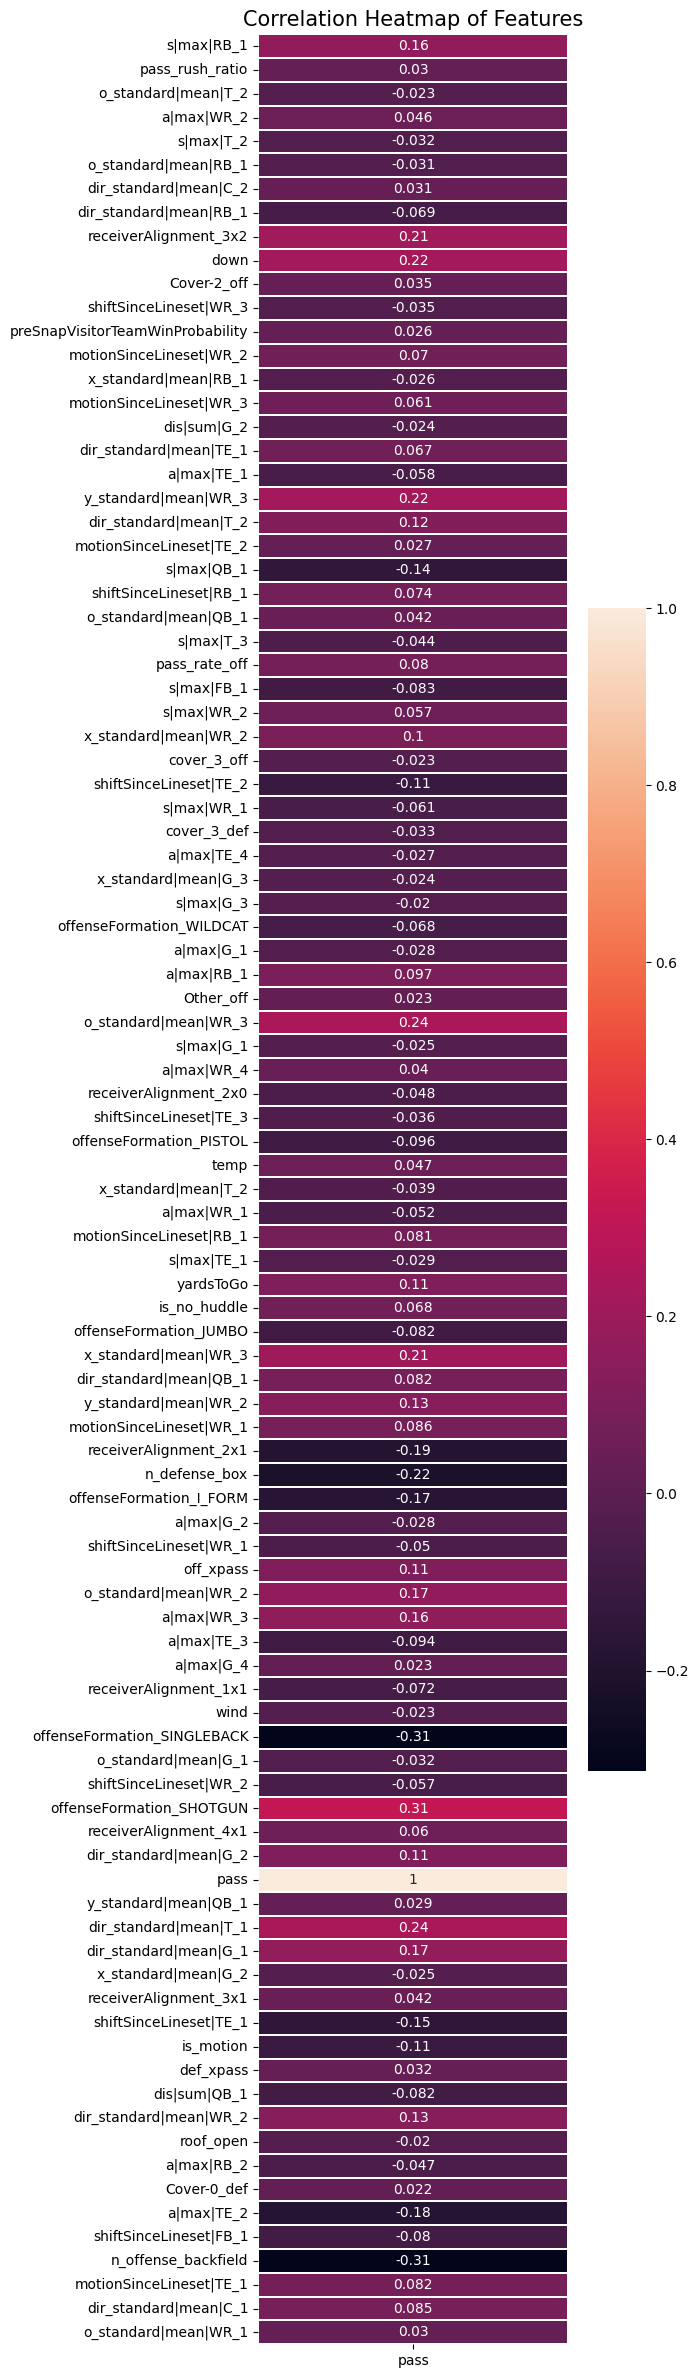

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(5,30))
plt.title('Correlation Heatmap of Features', size=15)

sns.heatmap(merged_pivot[final_features].corr()[['pass']],linewidths=0.1,vmax=1.0,  linecolor='white', annot=True)

In [42]:
# Create an imputer object with mean strategy
#imputer = SimpleImputer(strategy='mean')
from sklearn.compose import ColumnTransformer

# Fit and transform the data
#merged_pivot[numeric_columns] = imputer.fit_transform(merged_pivot[numeric_columns])
imputer = SimpleImputer(missing_values = np.nan,strategy='mean')
transformer = ColumnTransformer(
    transformers=[('imputer', imputer, numeric_columns),('scaler', MinMaxScaler(), numeric_columns)
    ],
    remainder='passthrough'  # Pass through columns not specified
)



In [43]:
#create a function to train ML models and return ROC_AUC and accuracy scores
SEED=42
n_splits=5
#X=merged_pivot[selected_features]
X=merged_pivot[final_features].drop(columns='pass')

y=merged_pivot['pass']


def TrainML(model_class, X, y):


    SKF = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    
    train_S = []
    test_S = []
    train_A = []
    test_A = []

    oof_non_rounded = np.zeros(len(y), dtype=float) 


    for fold, (train_idx, test_idx) in enumerate(tqdm(SKF.split(X, y), desc="Training Folds", total=n_splits)):
        X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]

        model = clone(model_class)
        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)
        oof_non_rounded[test_idx] = y_val_pred
       
     

        train_auc = roc_auc_score(y_train, y_train_pred.round(0).astype(int))
        val_auc = roc_auc_score(y_val, y_val_pred.round(0))

        train_S.append(train_auc)
        test_S.append(val_auc)

        train_accuracy = accuracy_score(y_train, y_train_pred.round(0).astype(int))
        val_accuracy = accuracy_score(y_val, y_val_pred.round(0))

        train_A.append(train_accuracy)
        test_A.append(val_accuracy)
       
        
        print(f"Fold {fold+1} - Train AUC: {train_auc:.4f}, Validation AUC: {val_auc:.4f}")
        clear_output(wait=True)

    print(f"Mean Train AUC --> {np.mean(train_S):.4f}")
    print(f"Mean Validation AUC ---> {np.mean(test_S):.4f}")
    print(f"Mean Train Accuracy --> {np.mean(train_A):.4f}")
    print(f"Mean Validation Accuracy ---> {np.mean(test_A):.4f}")
    
    cm = confusion_matrix(y_val, y_val_pred)

    cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [0, 1])

    cm_display.plot()
    plt.show()


Training Folds: 100%|██████████| 5/5 [00:00<00:00,  8.90it/s]

Mean Train AUC --> 0.5000
Mean Validation AUC ---> 0.5000
Mean Train Accuracy --> 0.6046
Mean Validation Accuracy ---> 0.6046


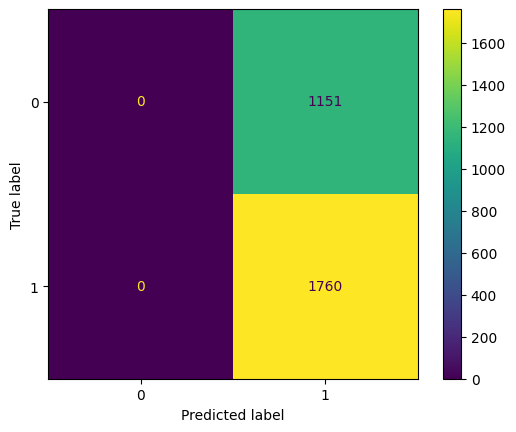

In [44]:
#get baseline value from dummy classifier
dummypipeline=Pipeline([('tr', transformer), ('dummy', DummyClassifier(strategy="most_frequent"))], verbose = True)
TrainML(dummypipeline,X, y )

Training Folds: 100%|██████████| 5/5 [00:14<00:00,  2.88s/it]

Mean Train AUC --> 0.8995
Mean Validation AUC ---> 0.7869
Mean Train Accuracy --> 0.9048
Mean Validation Accuracy ---> 0.7987


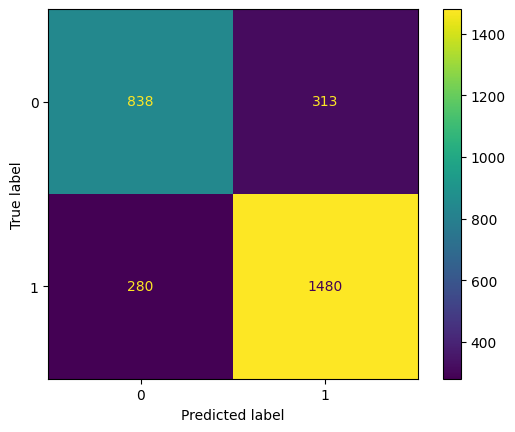

In [45]:
#lgbm classifier
pipeline=Pipeline([('tr', transformer), ('lgbm', LGBMClassifier(verbosity=-1))], verbose = True)
TrainML(pipeline,X, y )

Training Folds: 100%|██████████| 5/5 [01:54<00:00, 22.99s/it]

Mean Train AUC --> 0.9085
Mean Validation AUC ---> 0.7920
Mean Train Accuracy --> 0.9147
Mean Validation Accuracy ---> 0.8038


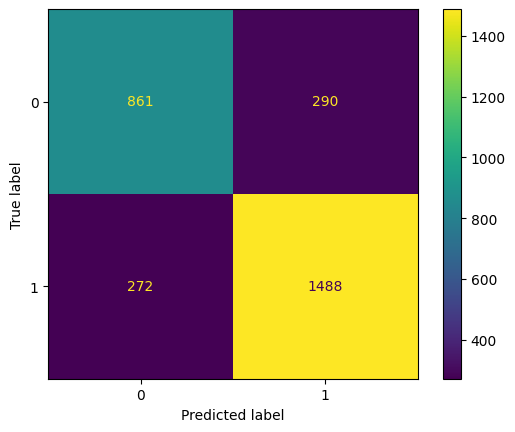

In [46]:
#catboost classifier
pipeline=Pipeline([('tr', transformer), ('cat', CatBoostClassifier(  verbose=False))], verbose = True)
TrainML(pipeline,X, y )

In [47]:
X['yardsToGo']=X['yardsToGo'].astype(float)

In [48]:
final_features.remove('pass')

In [49]:
[x for x in numeric_columns if 'FB' in x]

['s|max|FB_1']

In [50]:
#X_transform.isna().sum()

In [51]:
#pd.DataFrame(transformer_impute.fit_transform(X), columns=final_features).isna().sum()

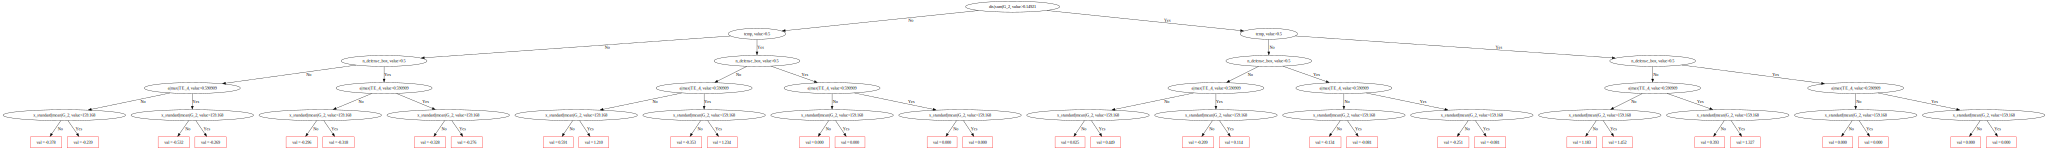

In [52]:
from catboost import  Pool, MetricVisualizer
import ipywidgets as widgets
%matplotlib inline

# For explicitly displaying widgets
from IPython.display import display

transformer_impute = ColumnTransformer(
    transformers=[('imputer', imputer, numeric_columns)
    ],
    remainder='passthrough'  # Pass through columns not specified
)

transformer_scale = ColumnTransformer(
    transformers=[
        ('scaler', MinMaxScaler(), numeric_columns)
    ],
    remainder='passthrough'  # Pass through columns not specified
)

X=merged_pivot[final_features]

y=merged_pivot['pass']
numeric_columns=[]
is_cat = (X.dtypes != float)
for feature, feat_is_cat in is_cat.to_dict().items():
    if feat_is_cat:
        X[feature].fillna(0, inplace=True)
    else:
        numeric_columns.append(feature)

X_transform=transformer_impute.fit_transform(X)

X_transform = pd.DataFrame(X_transform, columns=final_features)

X_transform=transformer_scale.fit_transform(X_transform)

X_transform = pd.DataFrame(X_transform, columns=final_features)

for feature, feat_is_cat in is_cat.to_dict().items():
    if feat_is_cat:
        X_transform[feature]=X_transform[feature].astype(int)

cat_features_index = np.where(is_cat)[0]
pool = Pool(X_transform, y, cat_features=cat_features_index, feature_names=list(X_transform.columns))




model = CatBoostClassifier( max_depth=5,
    verbose=False,  iterations=2).fit(pool)

model.plot_tree(
    tree_idx=1,
    pool=pool
)

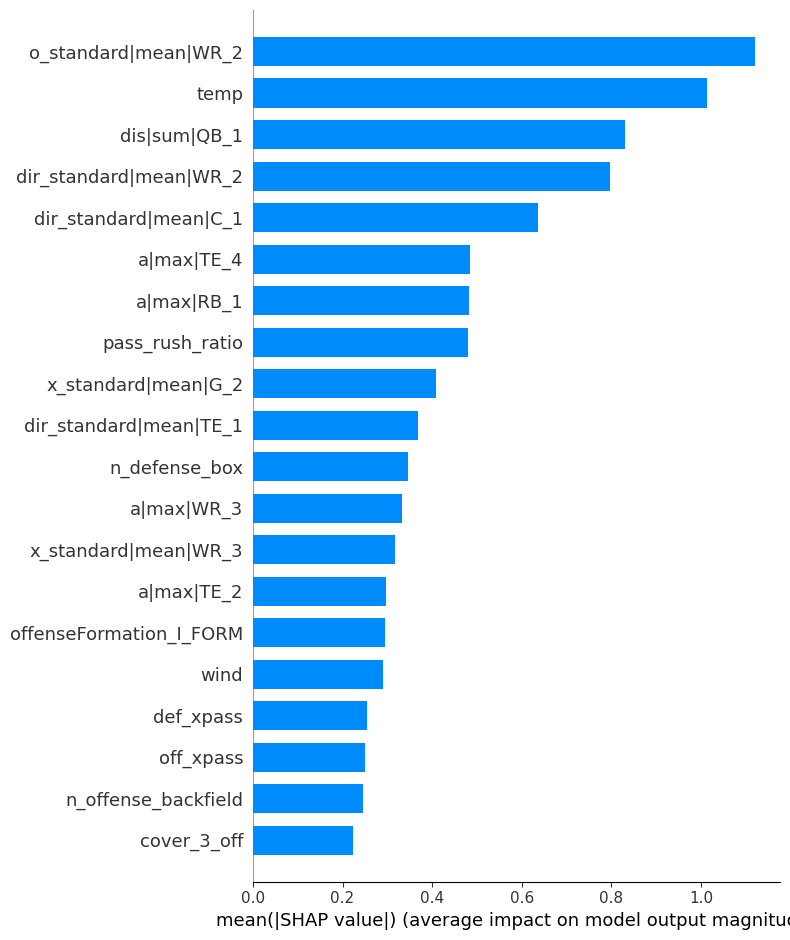

In [53]:
import shap
model = CatBoostClassifier( 
    verbose=False).fit(pool)
shap_values = model.get_feature_importance(Pool(X, label=y, cat_features=cat_features_index),type="ShapValues")
shap_values = shap_values[:, :-1]
shap.summary_plot(shap_values, X, plot_type="bar")

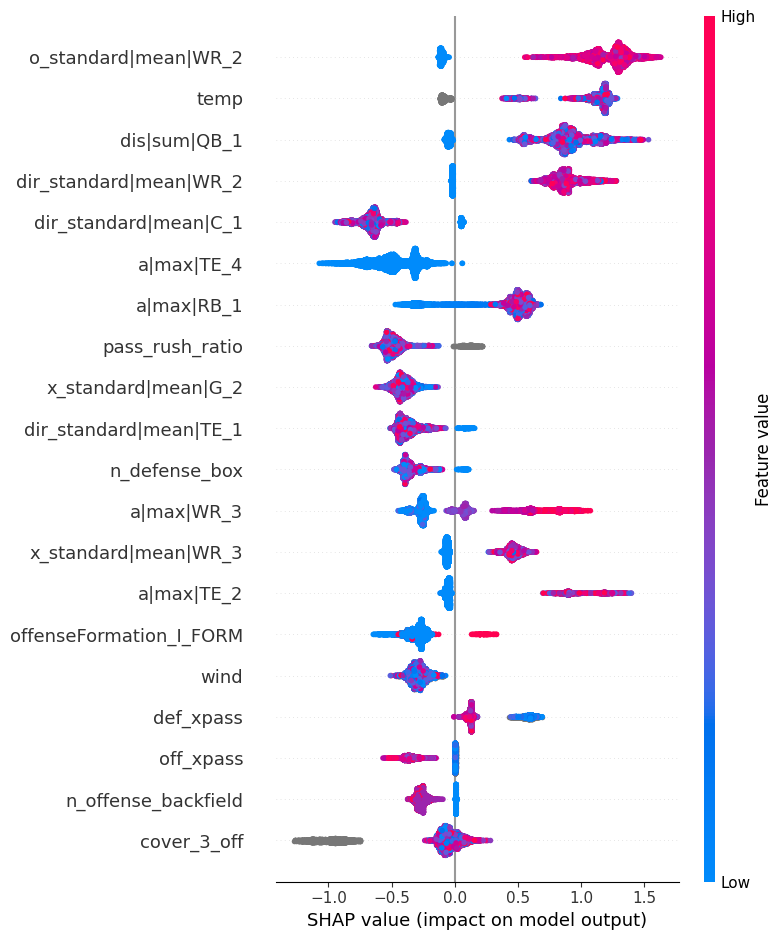

In [54]:
shap.summary_plot(shap_values, X)

In [55]:
importances =model.get_feature_importance(type='PredictionValuesChange')
feature_importances=pd.Series(importances, index=X.columns).sort_values()
feature_importance_df=pd.DataFrame(feature_importances, columns=[ 'importance']).sort_values('importance', ascending=False)
selected_features=list(feature_importance_df.head(len(final_features)).T.columns)
top_30_features=list(feature_importance_df.head(30).T.columns)
top_30_features.append('pass')

In [56]:
list(top_30_features)

['temp',
 'offenseFormation_I_FORM',
 'a|max|WR_3',
 'def_xpass',
 'cover_3_off',
 'a|max|TE_4',
 'x_standard|mean|G_2',
 'o_standard|mean|WR_2',
 'a|max|RB_1',
 'wind',
 'Other_off',
 'pass_rush_ratio',
 's|max|RB_1',
 's|max|FB_1',
 'dis|sum|QB_1',
 'x_standard|mean|T_2',
 'a|max|TE_2',
 'o_standard|mean|WR_1',
 'dir_standard|mean|TE_1',
 'a|max|TE_1',
 'a|max|WR_4',
 'n_defense_box',
 'dir_standard|mean|C_1',
 'preSnapVisitorTeamWinProbability',
 'x_standard|mean|WR_2',
 'a|max|WR_2',
 's|max|WR_1',
 'cover_3_def',
 'a|max|TE_3',
 'Cover-2_off',
 'pass']

In [57]:
!pip install pandas numpy matplotlib seaborn holoviews
!pip install autoviz
from autoviz.AutoViz_Class import AutoViz_Class

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.5/67.5 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.2/161.2 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 70.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.9/255.9 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 50.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 45.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.5/96.5 kB 4.8 MB/s eta 0:00:00
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.4
    Uninstalling nltk-3.2.4:
      Successfully uninstalled nltk-3.2.4
  Attempting uninstall: xgboost
    Found existing installation: xgboost 2.0.3
    Uninstalling xgboost-2.0.3:
      Successfully uninstalled xgbo

In [58]:
'''
%matplotlib inline

AV = AutoViz_Class()

AV.AutoViz("", dfte=merged_pivot[top_30_features].corr(), depVar='pass', verbose=0)
'''

'\n%matplotlib inline\n\nAV = AutoViz_Class()\n\nAV.AutoViz("", dfte=merged_pivot[top_30_features].corr(), depVar=\'pass\', verbose=0)\n'

In [59]:
final_cat_columns=[]
for c in cat_columns:
    if c in selected_features:
        final_cat_columns.append(c)

In [60]:
final_numeric_columns=[]
for i in selected_features:
       if merged_pivot[i].dtype!='O' and i!='pass' and 'shiftSinceLineset' not in i and 'motionSinceLineset' not in i and  'offenseFormation' not in i and'receiverAlignment'not in i and 'Cover'not in i and 'roof' not in i and 'surface' not in i and 'is_no_huddle' not in i and 'is_no_motion' not in i:
            final_numeric_columns.append(i)
    

In [61]:
from sklearn.compose import ColumnTransformer
# Create a transformer
imputer = SimpleImputer(missing_values=np.nan,strategy='mean')
transformer = ColumnTransformer(
    transformers=[('imputer', imputer, final_numeric_columns),
        ('scaler', MinMaxScaler(), final_numeric_columns)
    ],
    remainder='passthrough'  # Pass through columns not specified
)

In [62]:
SKF = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
X=merged_pivot[selected_features]

y=merged_pivot['pass']
# Define the helper function so that it can be reused
def tune(objective):
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=30, show_progress_bar=True)

    params = study.best_params
    best_score = study.best_value
    print(f"Best score: {best_score}\n")
    print(f"Optimized parameters: {params}\n")
    return params

def objective(trial):
    param = {
        "learning_rate": trial.suggest_float("learning_rate", 2e-2, 1e-1, log=True),
         "depth": trial.suggest_int("depth",4,9),
        "subsample": trial.suggest_float("subsample", 0.4, .95),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.2, .95),
        "iterations":trial.suggest_int("iterations",200, 700 )
        
    }
    cat = CatBoostClassifier(**param,  logging_level='Silent')  
    pipeline=Pipeline([('tr', transformer), ('cat',  cat)], verbose = False)
    scores = cross_val_score( pipeline, X, y, cv=SKF, scoring="accuracy")
    return scores.mean()
#cat_params = tune(objective)

In [63]:
cat_params={'learning_rate': 0.09266434349818461, 'depth': 8, 'subsample': 0.9490011978490482, 'colsample_bylevel': 0.8112961715549822, 'iterations': 469}

In [64]:
#catboost classifier
pipeline=Pipeline([('tr', transformer), ('cat', CatBoostClassifier(  **cat_params, verbose=False))], verbose = True)
TrainML(pipeline,X, y )

Training Folds: 100%|██████████| 5/5 [03:32<00:00, 42.44s/it]

Mean Train AUC --> 0.9980
Mean Validation AUC ---> 0.7878
Mean Train Accuracy --> 0.9984
Mean Validation Accuracy ---> 0.7999


In [65]:
uniqueplays=len(merged_pivot)
playswithpasses=len(merged_pivot[merged_pivot['pass']==1])

print('Unique plays:' , uniqueplays)
print('Unique plays with passes:' ,playswithpasses )
print('% Plays with Pass Attempts: ', round((playswithpasses/uniqueplays)*100, 1), '%')

Unique plays: 14556
Unique plays with passes: 8801
% Plays with Pass Attempts:  60.5 %


In [66]:
X=merged_pivot[selected_features]

y=merged_pivot['pass']



X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp,stratify=y_temp,  test_size=0.5, random_state=42)


In [67]:

tf.random.set_seed(42)
# Define the MLP model
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=10,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights to the epoch with the best value of the monitored quantity
)
# Create MLP model

model = Sequential()
model.add(Dense(64, input_dim=X.shape[1], activation='relu'))
model.add(Dropout(.005))
model.add(Dense(32, input_dim=X.shape[1], activation='relu'))
model.add(Dense(16, input_dim=X.shape[1], activation='relu'))
model.add(Dropout(.005))
model.add(Dense(8, input_dim=X.shape[1], activation='relu'))
model.add(Dropout(.005))
model.add(Dense(1, activation='sigmoid'))
initial_weights = model.get_weights()
optimizer = keras.optimizers.Adam(.004)

model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])


In [68]:
def calculate_and_plot_metrics(X_train, y_train, X_val_scaled, y_val, X_test_scaled, y_test, title):

    history=model.fit(X_train_scaled, y_train,  epochs=250,validation_data=(X_val_scaled, y_val),callbacks=[early_stopping])

    y_pred = model.predict(X_test_scaled)

    # Calculate metrics
    def calculate_metrics(y_true, y_pred):
        accuracy = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, average='weighted')
        precision = precision_score(y_true, y_pred, average='weighted', zero_division=1)
        recall = recall_score(y_true, y_pred, average='weighted')
        roc_auc=roc_auc_score(y_true, y_pred)
        return accuracy, f1, precision, recall, roc_auc

    y_preds=[]
    for i in y_pred:
        if i>.5:
            y_preds.append(1)
        else:
            y_preds.append(0)
 
    # Metrics for MLP
    accuracy_mlp, f1_mlp, precision_mlp, recall_mlp, roc = calculate_metrics(y_test, y_preds)


    fig, axes = plt.subplots(1, 2, figsize=(7, 4))

    # Confusion Matrix and Visualization 
    cm_mlp = confusion_matrix(y_test, y_preds)
    disp_mlp = ConfusionMatrixDisplay(confusion_matrix=cm_mlp)
    disp_mlp.plot(cmap='viridis', values_format='d', ax=axes[0])
    axes[0].set_title("MLP Confusion Matrix")

    # Loss Curve 
    loss_values = history.history['loss']
    epochs = range(1, len(loss_values)+1)

    axes[1].plot(epochs, loss_values, label='Training Loss')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Loss')

 

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

    return accuracy_mlp, f1_mlp, precision_mlp, recall_mlp, roc

In [69]:

#accuracy1_mlp, f1_1_mlp, precision1_mlp, recall1_mlp, roc = calculate_and_plot_metrics(X_train_scaled, y_train, X_val_scaled, y_val,X_test_scaled, y_test, "Pass Probability Keras MLP")


#print(f"Accuracy: {accuracy1_mlp:.4f}\nF1 Score: {f1_1_mlp:.4f}\nPrecision: {precision1_mlp:.4f}\nRecall: {recall1_mlp:.4f}\nROC AUC: {roc:.4f}\n")




In [70]:
from tensorflow.keras.utils import plot_model
# Plot the model
#plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)